In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
  
from sklearn import neighbors
    
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


from sklearn.ensemble import RandomForestClassifier


# Data Import & Clean

In [2]:
df = pd.read_csv('titanic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
df.head(1)
del df['PassengerId']

In [4]:
df.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [5]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Age'].isna().sum()

0

In [8]:
#df['Embarked'] = df.dropna(axis='columns')
df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [9]:
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked'].isna().sum()

0

In [10]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

In [11]:
df['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [12]:
del df['Cabin']

In [13]:
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [14]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [15]:
sexdummy = pd.get_dummies(df['Sex'])
del sexdummy['male'] 
df['Sex_female'] = sexdummy
del df['Sex']

In [16]:
df['Survived'].max()

1

In [17]:
df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [18]:
df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
port = {"S": 0, "C": 1, "Q": 2}
df['Embarked'] = df['Embarked'].map(port)

In [20]:
df['Survived'].max()

1

In [21]:
df['Age'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [22]:
df.loc[(df['Age'] <= 22), 'Age'] = 1
df.loc[(df['Age'] > 22) & (df['Age'] <= 28), 'Age'] = 2
df.loc[(df['Age'] > 28) & (df['Age'] <= 35), 'Age'] = 3
df.loc[(df['Age'] > 35), 'Age'] = 4

In [23]:
df['Survived'].max()

1

In [24]:
df['Age'].min()

1.0

In [25]:
df['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [111]:
df[(df['Sex_female'] == 0) & (df['Survived'] == 1)].head(4)

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female
17,1,2,"Williams, Mr. Charles Eugene",2.0,0,0,244373,13.0000,0,0
21,1,2,"Beesley, Mr. Lawrence",3.0,0,0,248698,13.0000,0,0
23,1,1,"Sloper, Mr. William Thompson",2.0,0,0,113788,35.5000,0,0
36,1,3,"Mamee, Mr. Hanna",2.0,0,0,2677,7.2292,1,0


In [26]:
df.head(10)

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female
0,0,3,"Braund, Mr. Owen Harris",1.0,1,0,A/5 21171,7.2500,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",4.0,1,0,PC 17599,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",2.0,0,0,STON/O2. 3101282,7.9250,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",3.0,1,0,113803,53.1000,0,1
4,0,3,"Allen, Mr. William Henry",3.0,0,0,373450,8.0500,0,0
5,0,3,"Moran, Mr. James",2.0,0,0,330877,8.4583,2,0
6,0,1,"McCarthy, Mr. Timothy J",4.0,0,0,17463,51.8625,0,0
7,0,3,"Palsson, Master. Gosta Leonard",1.0,3,1,349909,21.0750,0,0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2.0,0,2,347742,11.1333,0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1.0,1,0,237736,30.0708,1,1


In [27]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked', 'Sex_female'],
      dtype='object')

# Logistic Regression Classifier

In [28]:
X = df[['Pclass', 'Sex_female', 'Age', 'SibSp', 'Parch','Fare', 'Embarked']]
y = df['Survived']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [30]:
len(X_train), len(y_train)

(712, 712)

In [31]:
len(X_test), len(y_test)

(179, 179)

In [32]:
lm = LogisticRegression(solver= 'liblinear', max_iter= 1000)
lm.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
print (lm.intercept_)

[1.13406894]


In [34]:
list(zip(lm.coef_[0,:] , X.columns.values )) 

[(-0.8643238372526021, 'Pclass'),
 (2.5461340312268876, 'Sex_female'),
 (-0.26720713314181405, 'Age'),
 (-0.30304759258871933, 'SibSp'),
 (-0.004537481170732491, 'Parch'),
 (0.002555623439217164, 'Fare'),
 (0.20059346351758456, 'Embarked')]

In [35]:
y_hat = lm.predict(X_train)
m = confusion_matrix(y_train, y_hat)
print(m)

[[383  56]
 [ 87 186]]


In [36]:
import statsmodels.api as sm

In [37]:
FN = m[1,0]
TP = m[0,0]
FP = m[0,1]
TN = m[1,1]

#FNR
FNR = FN / (FN + TP)
#FPR
FPR = FP / (FP + TN)
Acc = float(TP + TN)/(FP + FN + TP + TN)
TPR = float(TP)/(FN + TP)
print (FNR,FPR)
print ('Prediction accuracy: %f' %Acc )

0.1851063829787234 0.23140495867768596
Prediction accuracy: 0.799157


In [38]:
#apply lm to test set
y_hat = lm.predict(X_test)
m = confusion_matrix(y_test, y_hat)
print(m)

[[94 16]
 [18 51]]


In [39]:
FN = m[1,0]
TP = m[0,0]
FP = m[0,1]
TN = m[1,1]

#FNR
FNR = FN / (FN + TP)
#FPR
FPR = FP / (FP + TN)
Acc = float(TP + TN)/(FP + FN + TP + TN)
TPR = float(TP)/(FN + TP)
print (FNR,FPR)
print ('Prediction accuracy: %f' %Acc )

0.16071428571428573 0.23880597014925373
Prediction accuracy: 0.810056


#newton-cg
lg = LogisticRegression(solver = 'newton-cg', max_iter = 100000)
lg.fit(X, y)

print (lm.intercept_)
print (lm.coef_)

In [40]:
#lbfgs gets better prediction
lm = LogisticRegression(solver = 'lbfgs', max_iter  = 10000)
lm.fit(X_train,y_train)
print(lm.coef_)
print(lm.intercept_)

[[-9.38038942e-01  2.54280875e+00 -3.07148639e-01 -3.06490118e-01
   3.12460323e-03  1.92908937e-03  2.01315291e-01]]
[1.42409418]


In [41]:
print(cross_val_score(lm,X_train,y_train,cv=10, scoring = 'accuracy').mean())

0.7977822490498545


In [42]:
y_hat = lm.predict(X_train)
m = confusion_matrix(y_train, y_hat)
print(m)

[[387  52]
 [ 87 186]]


In [43]:
print ('correct predict survive:', m[0,0])
print ('correct predict no survive:', m[1,1])

correct predict survive: 387
correct predict no survive: 186


In [44]:
print ('predict accuracy:',(m[0,0]+m[1,1])/len(y_train))

predict accuracy: 0.8047752808988764


In [45]:
y_hat = lm.predict(X_test)
m = confusion_matrix(y_test, y_hat)
print(m)

[[96 14]
 [20 49]]


In [46]:
print ('correct predict survive:', m[0,0])
print ('correct predict no survive:', m[1,1])

correct predict survive: 96
correct predict no survive: 49


In [47]:
print ('predict accuracy:',(m[0,0]+m[1,1])/len(y_test))

predict accuracy: 0.8100558659217877


# Don't need CV

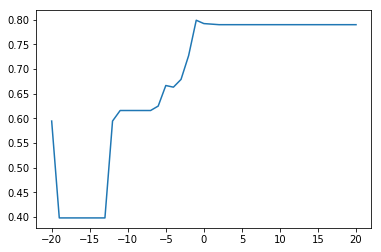

Our optimal C is -1.000000
Our accuracy at optimal C is 0.799133


In [50]:
#c v 
cv_range = np.logspace(-20,20,41) 
cv_index = np.linspace(-20,20,41)

cv_scores = []
for cv_score in cv_range:
    lm1 = LogisticRegression(C= cv_score, solver= 'lbfgs', max_iter  = 10000, penalty = 'l2')
    cv_scores.append(cross_val_score(lm1, X, y,cv = 10, scoring = 'accuracy').mean())

plt.plot(cv_index, cv_scores)
plt.show()

print("Our optimal C is %f" %cv_index[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))

In [ ]:
def PickThreshhold(Predictprob, Threshhold): 
        y_predict = 0
        if (Predictprob >= Threshhold):
            y_predict = 1
        return y_predict
   

In [ ]:
y_hat_probability = lm.predict_proba(X).T[1]
ThreshholdRange =  np.linspace(0, 1, 100)

In [ ]:
FPR_List = []
FNR_List = []
TPR_List = []
Err_List = []

for i in ThreshholdRange:
    y_hat_predict_threshhold = []
    for j in range(0,len(y_hat_probability)):
            y_hat_predict_threshhold.append(PickThreshhold(y_hat_probability[j],i))
            
    m = confusion_matrix(y, y_hat_predict_threshhold)

    FN = m[1,0]
    TP = m[0,0]
    FP = m[0,1]
    TN = m[1,1]

    #FNR
    FNR = FN / (FN + TP)
    #FPR
    FPR = FP / (FP + TN)
  
    Acc = float(TP + TN)/(FP + FN + TP + TN)
    Err = float(FP + FN)/(FN + TP + FP + TN)
    
    TPR = float(TP)/(FN + TP)
    
    FPR_List.append(FPR)
    FNR_List.append(FNR)
    Err_List.append(Err)
    
    TPR_List.append(TPR)
    


    

plt.plot(ThreshholdRange, FPR_List, color = 'r', label = 'False Positive Rate')
plt.plot(ThreshholdRange, FNR_List, color = 'b', label = 'False Negative Rate')
plt.plot(ThreshholdRange, Err_List, color = 'g', label = 'Err')
plt.xlabel("Threshhold")
plt.ylabel("Error")
plt.legend()
plt.show()


# KNN

In [146]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,2.379349,0.523008,0.381594,32.204208,0.361392,0.352413
std,0.486592,0.836071,1.114652,1.102743,0.806057,49.693429,0.635673,0.477990
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,2.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,3.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,1.000000,3.000000,4.000000,8.000000,6.000000,512.329200,2.000000,1.000000


In [174]:
def Standardize(X):
    X_Standardized = (X - X.min())/(X.max() - X.min())
    return X_Standardized



In [175]:
df_KNN = df[df.columns.values]
df_KNN.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female
0,0,3,"Braund, Mr. Owen Harris",1.0,1,0,A/5 21171,7.2500,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",4.0,1,0,PC 17599,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",2.0,0,0,STON/O2. 3101282,7.9250,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",3.0,1,0,113803,53.1000,0,1
4,0,3,"Allen, Mr. William Henry",3.0,0,0,373450,8.0500,0,0


In [176]:
df_KNN['Fare'] = Standardize(df_KNN['Fare'])

In [177]:
df_KNN['Fare'].describe()

count    891.000000
mean       0.062858
std        0.096995
min        0.000000
25%        0.015440
50%        0.028213
75%        0.060508
max        1.000000
Name: Fare, dtype: float64

In [211]:
X = df_KNN[df_KNN.columns.values]
del X['Survived']
del X['Name'] 
del X['Ticket']
y = df_KNN['Survived']

In [217]:
y.sum()

342

# 'Age' STD??

In [247]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')

In [248]:
Score1 = knn.score(X, y)

y_hat = knn.predict(X)
Score2 = float(sum(y_hat == y))/len(df_KNN)

print(Score1)
print(Score2)

0.941638608305275
0.941638608305275


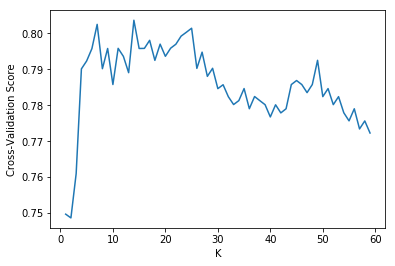

(0.8036911247304506, 14)


In [249]:
CV_Scores = []
RangeOfK = range(1,60)

for k in RangeOfK:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights= 'uniform')
    CV_Scores.append(cross_val_score(knn, X, y, cv=10, scoring = 'accuracy').mean())    

plt.plot(RangeOfK, CV_Scores)
plt.xlabel("K")
plt.ylabel("Cross-Validation Score")
plt.show()
print (max(list(zip(CV_Scores, RangeOfK))))

In [251]:
print(RangeOfK[np.argmax(CV_Scores)]) 

14


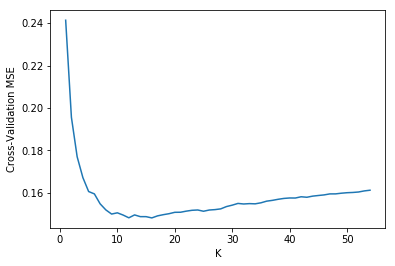

(0.1480690152933833, 16)


In [245]:
CV_Scores = []
RangeOfK = range(1,55)

for k in RangeOfK:
    knn = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    CV_Scores.append( -cross_val_score(knn, X, y, cv=10,
                                    scoring = 'neg_mean_squared_error').mean())    


plt.plot(RangeOfK, CV_Scores)
plt.xlabel("K")
plt.ylabel("Cross-Validation MSE")
plt.show()
print (min(list(zip(CV_Scores, RangeOfK))))

In [246]:
print(RangeOfK[np.argmin(CV_Scores)]) 

16


ValueError: x and y must be the same size

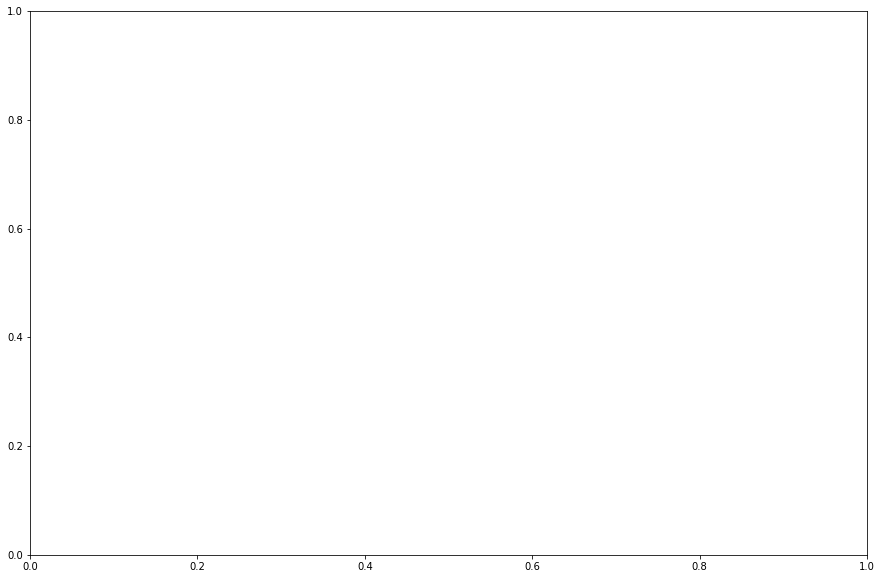

In [223]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')

knn_1 = neighbors.KNeighborsRegressor(n_neighbors = 1, weights='distance')
knn_3 = neighbors.KNeighborsRegressor(n_neighbors = 3, weights='distance')
knn_10 = neighbors.KNeighborsRegressor(n_neighbors = 16, weights='distance')


knn_1.fit(X,y)
y_hat_1 = knn_1.predict(X)

knn_3.fit(X,y)
y_hat_3 = knn_3.predict(X)

knn_10.fit(X,y)
y_hat_10 = knn_10.predict(X)


plt.figure(figsize=(15,10))
plt.scatter(X, y_hat_1, label='data')

plt.plot(X, y_hat_3, c = 'g',label='prediction K=3')
plt.plot(X, y_hat_10, c = 'k',label='prediction K=10')

plt.xlabel("X Variable")
plt.ylabel("Y Variable")
plt.legend()
plt.show()

ValueError: x and y must be the same size

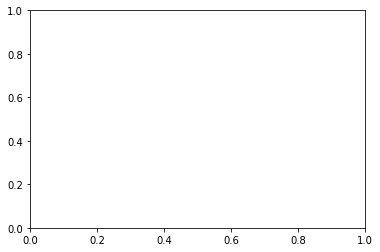

In [224]:
plt.scatter(X, y, label='data')

# Decision Tree Classifier

In [93]:
df.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female
0,0,3,"Braund, Mr. Owen Harris",1.0,1,0,A/5 21171,7.2500,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",4.0,1,0,PC 17599,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",2.0,0,0,STON/O2. 3101282,7.9250,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",3.0,1,0,113803,53.1000,0,1
4,0,3,"Allen, Mr. William Henry",3.0,0,0,373450,8.0500,0,0


In [94]:
X = df[df.columns.values]
del X['Survived']
del X['Name'] 
del X['Ticket']
y = df['Survived']

 # We deal with name later X['Name'].value_counts().sum

In [95]:
y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

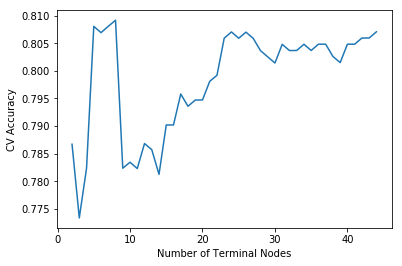

In [100]:
Maximum_Terminal_Nodes = range(2,45)
score = []
for i in Maximum_Terminal_Nodes:
    TreeClass = DecisionTreeClassifier(max_leaf_nodes = i, 
                                       min_samples_leaf = 5, 
                                       random_state = 100)
    score.append((cross_val_score(TreeClass, X, y, cv=10, scoring = 'accuracy')).mean())

plt.plot(Maximum_Terminal_Nodes, score)
plt.xlabel("Number of Terminal Nodes")
plt.ylabel("CV Accuracy")
plt.show()

In [101]:
CV_MSE_Max = np.argmax(score)
Maximum_Terminal_Node = Maximum_Terminal_Nodes[CV_MSE_Max]
print("The best option for maximum terminal node is %i which results in accuracy = %f" %(Maximum_Terminal_Node, np.max(score)))

The best option for maximum terminal node is 8 which results in accuracy = 0.809171


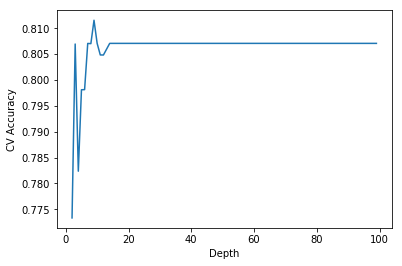

In [121]:
Maximum_Depth = range(2,100)
score = []
for i in Maximum_Depth:
    TreeClass = DecisionTreeClassifier(max_depth = i, 
                                       min_samples_leaf = 5, 
                                       random_state = 24)
    score.append((cross_val_score(TreeClass, X, y, cv=10, scoring = 'accuracy')).mean())

plt.plot(Maximum_Depth, score)
plt.xlabel("Depth")
plt.ylabel("CV Accuracy")
plt.show()

In [122]:
CV_MSE_Max = np.argmax(score)
Maximum_Depth = Maximum_Depth[CV_MSE_Max]

print("The best option for maximum depth is %i which results in accuracy = %f" %(Maximum_Depth, np.max(score)))

The best option for maximum depth is 9 which results in accuracy = 0.811531


In [125]:
TreeClass = DecisionTreeClassifier(
                max_depth = 9,
                min_samples_leaf = 8,
                random_state = 24)

TreeClass.fit(X,y)

ImportanceDataFrame = pd.DataFrame({'feature':X.columns.values, 'importance':TreeClass.feature_importances_})
ImportanceDataFrame.sort_values(by = ['importance'], ascending = 0)

,feature,importance
6,Sex_female,0.525245
4,Fare,0.237008
0,Pclass,0.132803
1,Age,0.040528
3,Parch,0.030518
2,SibSp,0.020677
5,Embarked,0.013222


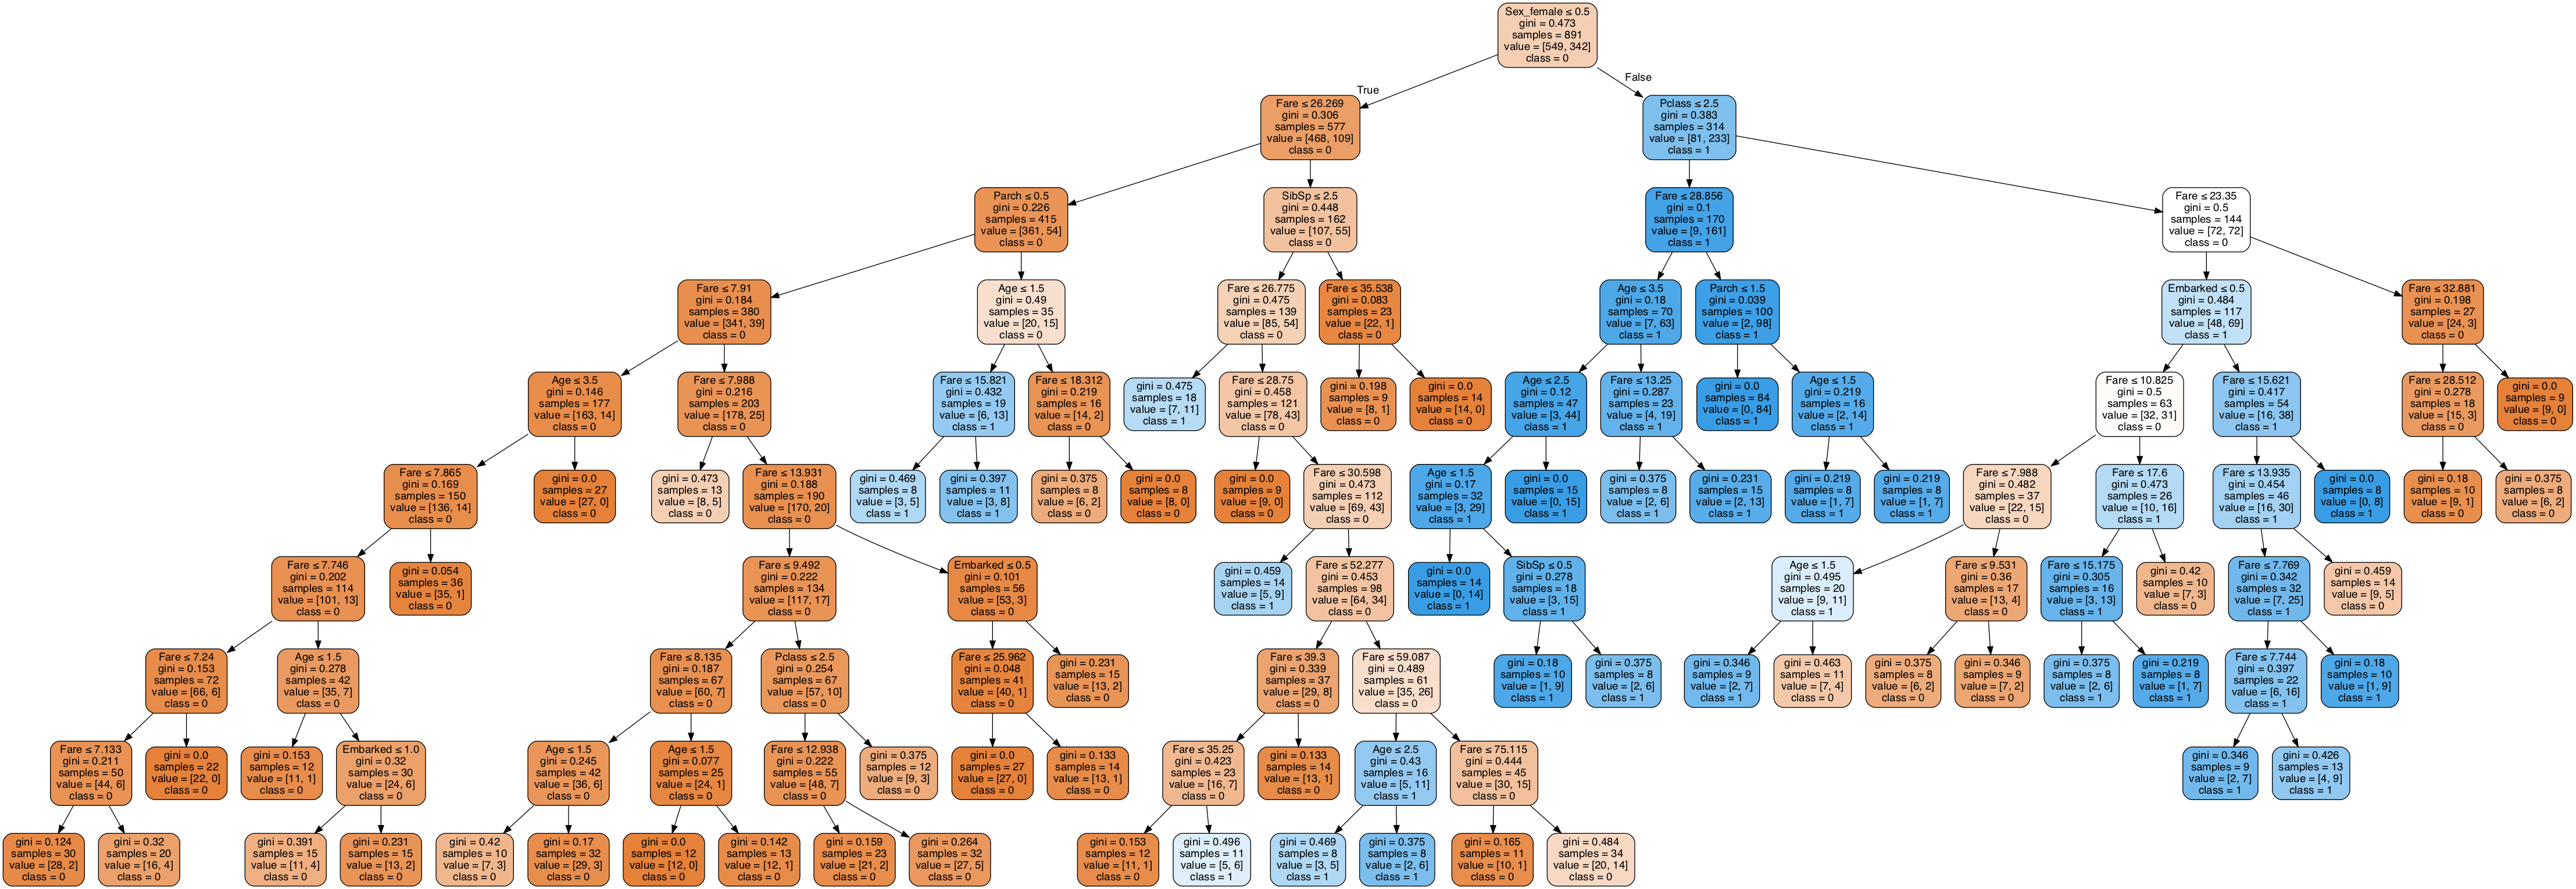

In [126]:
dot_data = StringIO()
feature_cols = X.columns
export_graphviz(TreeClass, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Titanic_tree.png')
Image(graph.create_png())

,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female
0,3,1.0,1,0,7.2500,0,0
1,1,4.0,1,0,71.2833,1,1
2,3,2.0,0,0,7.9250,0,1
3,1,3.0,1,0,53.1000,0,1
4,3,3.0,0,0,8.0500,0,0


# Random Forest  Classification

In [130]:
RFClass = RandomForestClassifier(n_estimators = 1000, 
                                 max_features = 4, 
                                 min_samples_leaf = 10,
                                 oob_score = True,
                                 random_state = 1,
                                 n_jobs = -1)
RFClass.fit(X, y)
print("Out of Bag Accuracy  = %f" %RFClass.oob_score_)
scores = cross_val_score(RFClass, X, y, cv = 10)
print("Cross-validation Accuracy = %f" %scores.mean())

Out of Bag Accuracy  = 0.806958
Cross-validation Accuracy = 0.814864


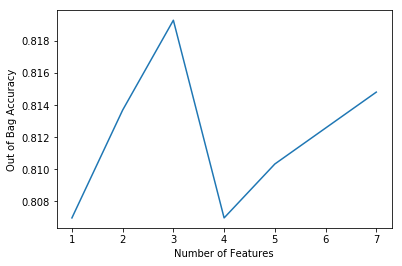

(0.819304152637486, 3)


In [145]:
Features = range(1,8)
oob_score_RF = []
for i in Features:
        RFClass = RandomForestClassifier(n_estimators = 1000, #Number of trees - the more the better!
                           max_features = i,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True,
                           random_state = 1,
                           n_jobs = -1)
        
        RFClass.fit(X,y)  
        oob_score_RF.append(RFClass.oob_score_)

plt.plot(Features, oob_score_RF)
plt.xlabel("Number of Features")
plt.ylabel("Out of Bag Accuracy")
plt.show()             

print (max(list(zip(oob_score_RF, Features)))) 

# it sounds like choosing max_features as 6 is our best bet

(0.819304152637486, 3)
